This code was originally written by Karen Perez, for GBT C-Band data. I generalized this code to calculate the spike channels for other bands at GBT. It now takes in an h5/filterbank file and its corresponding .dat file

Next steps: reduce dependance on having the .h5 file. This can be achieved by making an optional argument for either/both the number of course channels or the width of the course channels

In [1]:
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import csv
import blimpy as bl
import tqdm
import glob
import pandas as pd
import turbo_seti.find_event as find
import blimpy as bl
import time

In [2]:
%matplotlib inline

In [3]:
dat_files = [
    "dat_files/GBT_57523_69379_HIP17147_fine.dat", 
    "dat_files/GBT_57606_50058_HIP20901_fine.dat",
    "dat_files/GBT_57456_02669_HIP39826_fine.dat",
    "dat_files/GBT_57803_80733_HIP4436_fine.dat",  
    "dat_files/GBT_57599_55512_HIP45493_fine.dat", 
    "dat_files/GBT_57459_34297_HIP65352_fine.dat", 
    "dat_files/GBT_57650_54573_HIP66704_fine.dat", 
    "dat_files/GBT_57523_22406_HIP74981_fine.dat", 
    "dat_files/GBT_57680_15520_HIP7981_fine.dat",  
    "dat_files/GBT_57664_79761_HIP82860_fine.dat" 
]

In [4]:
h5_files = [
    "/mnt_blpd7/datax/dl/GBT_57523_69379_HIP17147_fine.h5",
    "/mnt_blpd7/datax/dl/GBT_57606_50058_HIP20901_fine.h5",
    "/mnt_blpd7/datax/dl/GBT_57456_02669_HIP39826_fine.h5",
    "/mnt_blpd7/datax2/dl/GBT_57803_80733_HIP4436_fine.h5",
    "/mnt_blpd7/datax/dl/GBT_57599_55512_HIP45493_fine.h5",
    "/mnt_blpd7/datax/dl/GBT_57459_34297_HIP65352_fine.h5",
    "/mnt_blpd7/datax2/dl/GBT_57650_54573_HIP66704_fine.h5",
    "/mnt_blpd7/datax/dl/GBT_57523_22406_HIP74981_fine.h5",
    "/mnt_blpd7/datax2/dl/GBT_57680_15520_HIP7981_fine.h5",
    "/mnt_blpd7/datax2/dl/GBT_57664_79761_HIP82860_fine.h5"
]

In [5]:
def grab_parameters(h5_file):
    """takes h5 file of GBT data and returns a list of channels and nfpc

    returns channels_list, fch1, foff, nfpc"""
    #read h5 file and grab frequency info from the header"
    test_file = h5_file
    fb = bl.Waterfall(test_file, load_data=False)
    head = fb.file_header
    
    fch1 = head["fch1"]
    foff = head["foff"]
    nchans=head["nchans"]
    fch1=float(fch1-(foff/2.0))
    
    nfpc=(1500.0/512.0)/abs(foff)
    channels_list=range(0,nchans+1)
    
    return channels_list, fch1, foff, nfpc

The `spike_channels` function is not a very efficient cell. It would be worth looking into to see if there are more efficient ways to make the list. 

It seems like we are just making a list that increments at some intervals (hopefully a periodic interval), so it would be worth seeing if we can use a numpy function to make it faster.

In [6]:
def spike_channels(channels_list, nfpc):
    """makes a spike channels list given a list of channels"""
    spike_channels_list=[]
    for i in channels_list: #should be smaller ~512 -> variable somewhere to store this that can be changed course channels list? 
        spike_channel=(nfpc/2.0)+(nfpc*i)
        spike_channels_list.append(spike_channel)
    print ('spike channels list done')
    return spike_channels_list

In [7]:
def freqs_fine_channels(spike_channels_list, fch1, foff):
    """docstring here"""
    freqs_fine_channels_list=[]
    for index, value in enumerate(spike_channels_list):
        freq_fine_channel=fch1+foff*value
        if freq_fine_channel>0:
            #print ('freq_fine_channel', freq_fine_channel)
            #num = str(freq_fine_channel)
            #i = num.index(".")
            #freq_fine_channel = num[:i + 7]
            freq_fine_channel=round(freq_fine_channel, 6)
            freqs_fine_channels_list.append(freq_fine_channel)
        else:
            break
    #print ('freqs_fine_channels list done', freqs_fine_channels_list)
    print ('end')
    np.save('freqs_fine_channels_list2.npy', freqs_fine_channels_list)
    return freqs_fine_channels_list

In [8]:
def wrapper_function(dat_file, freqs_fine_channels_list):
    """a wrapper function to encapsulate a function that I want to call multiple times"""
    file = dat_file

    if True:#"gpuspec.0000.dat" in file and ("A00_0025" in file or "C01_0026" in file or "C07_0027" in file or "A00_0028" in file or "C01_0029" in file or "C07_0030" in file or "A00_0031" in file or "C01_0032" in file):
    #if file.endswith("gpuspec.0000.dat") and "A00_0025" in file:    
        datfile_curr=file
        print ('datfile_curr', datfile_curr)
        #data=np.loadtxt(datfile_curr)
        file_contents = []
        # open file you wish to read
        with open(datfile_curr, 'r') as infile:
            for line in infile:
                file_contents.append(line)
        with open(datfile_curr+'new.dat', 'w') as outfile:
            for index, row in enumerate(file_contents):
                #row=row.split('\t')
                #print ('row', row)
                if index==0 or index==1 or index==2 or index==3 or index==4 or index==5 or index==6 or index==7 or index==8:
                    #newrow=row.strip('\n')
                    newrow=row.strip('\t')
                    #print ('row', newrow)
                    outfile.write(newrow)       
                else:
                    newrow=row.split('\t')
                    #print ('row', row)
                    row=row.split('\t')
                    #print ('row_postsplit', row)
                    freq=float(newrow[4])-(foff/2.0)
                    startfreq=float(newrow[6])-(foff/2.0)
                    endfreq=float(newrow[7])-(foff/2.0)
                    #freq=freq.strip(' ')
                    freq=round(freq, 6)
                    startfreq=round(startfreq,6)
                    endfreq=round(endfreq,6)
                    #print ('freq', freq)
                    #row[3]=str(freq)
                    #row[4]=str(freq)
                    #print ('rowwithadjfreq', row)
                    #string='\t'
                    #row = [i + string for i in row]

                    minfreq=(float(freq)-0.000001)
                    maxfreq=(float(freq)+0.000001)
                    #print ('minfreq', minfreq)
                    #print ('maxfreq', maxfreq)
                    #i= minfreq.index(".")
                    #minfreq = minfreq[:i + 7]
                    minfreq=round(minfreq,6)
                    #j= maxfreq.index(".")
                    #maxfreq = maxfreq[:j + 7]
                    maxfreq=round(maxfreq,6)
                    #print ('minfreq', minfreq)
                    #print ('maxfreq', maxfreq)
                    freq=str(freq)
                    minfreq=str(minfreq)
                    maxfreq=str(maxfreq)
                    if len((freq).split('.')[1])<6:
                        freq=format(float(freq), '.6f')
                    row[3]=str(freq)
                    row[4]=str(freq)
                    row[6]=str(startfreq)
                    row[7]=str(endfreq)
                    string='\t'
                    for index,value in enumerate(row[:-1]):
                        newvalue=value+string
                        row[index]=newvalue
                    #row = [i + string for i in row[:-1]]
                    if len((minfreq).split('.')[1])<6:
                        minfreq=format(float(minfreq), '.6f')
                    if len((maxfreq).split('.')[1])<6:
                        maxfreq=format(float(maxfreq), '.6f')
                    #print ('freq', freq)
                    #print ('minfreq', minfreq)
                    #print ('maxfreq', maxfreq)
                    if float(freq) in freqs_fine_channels_list:
                        pass#print ('bad freq', freq)
                    elif float(minfreq) in freqs_fine_channels_list:
                        pass#print ('bad min freq', minfreq)
                    elif float(maxfreq) in freqs_fine_channels_list:
                        pass#print ('bad max freq', maxfreq)
                    else:
                        glue='  '
                        #row=row.format()
                        row=glue.join(row)
                        #row=row.format()
                        #print ('finalrow', row)
                        outfile.write(str(row))
    print("done!\n")

# Importing spectral occupancy functions

Need to make this a class so that I can import it without getting errors

In [9]:
def calculate_hist(dat_file, bin_width=1): 
    """calculates a histogram of the number of hits for a single .dat file"""
    #read the file into a pandas dataframe
    tbl = find.read_dat(dat_file)

    #make the bins for the histogram
    min_freq = int(min(tbl["Freq"]))
    max_freq = np.round(max(tbl["Freq"]))
    bins = np.linspace(min_freq, max_freq, int((max_freq-min_freq)/bin_width) , endpoint=True)
    hist, bin_edges = np.histogram(tbl["Freq"], bins=bins)
    return hist, bin_edges

In [10]:
def calculate_proportion(file_list, bin_width=1, GBT=False):
    """Takes in a list of .dat files and makes a true/false table of hits in a frequency bin"""
    edges = []
    histograms = []
    min_freq = 0
    max_freq = 1e9
    
    #calculate histogram for the .dat file and check the boundaries on the data
    for file in file_list:
        hist, bin_edges = calculate_hist(file, bin_width)
        if min(bin_edges) > min_freq:
            min_freq = min(bin_edges)
        if max(bin_edges) < max_freq:
            max_freq = max(bin_edges)
        edges.append(bin_edges)
        histograms.append(hist)
    
    #make sure all lists are within the boundaries
    for i in range(len(edges)):
        within_boundaries = np.where( (edges[i] >= min_freq) & (edges[i] <= max_freq) ) #get the boundaries of the tightest frequency range
        edges[i] = edges[i][within_boundaries] # take only the entries within that range
        freq_boundaries = within_boundaries[0][:-1] # since the bins list has one more entry than frequencies, I will drop the last entry. the hit count will correspond with the frequency at the start of its bin
        histograms[i] = histograms[i][freq_boundaries] # take only the entries within that range
        
    #create the dataframe and add the frequency bins to column 0
    df = pd.DataFrame()
    df.insert(0, "freq", edges[0][:-1])
    
    #check if there is a hit in the frequency bin and insert value to dataframe
    for i in range(len(histograms)):
        colname = "file"+str(i)
        found_hit = histograms[i] > 0
        df.insert(len(df.columns), colname, found_hit.astype(int))
    
    #exclude entries in the GBT data due to the notch filter exclusion
    bin_edges = np.linspace(min_freq, max_freq, int((max_freq-min_freq)/bin_width), endpoint=True)
    if GBT:
        df = df[(df["freq"] < 1200) | (df["freq"] > 1341)]
        first_edge = np.arange(min_freq, 1200, bin_width)
        second_edge= np.arange(1341, max_freq, bin_width) #may or may not need max_freq+1
        bin_edges = np.append(first_edge, second_edge)
    
        
    # sum up the number of entries that have a hit and divide by the number of .dat files
    data_labels = df.columns[2:]
    total = df["file0"]
    for label in data_labels:
        total = total + df[label]
    
    return bin_edges, total/len(file_list) 

# Changing some of the old functions to make them less dependant on having access to the original h5 file 

My goal is to make the `grab_parameters` function no longer dependant on the h5 file, potentially with the ability to pass in the parameters that will work for the set of files as a whole

~I cannot get the correct DC removal with a fixed value of `foff`. I need to see if there is a way to get its value from something in the dat file~

I was able to get the `foff` value from the `.dat` file. The value from the dat file only has 7 sig figs, while the h5 file provides 16 sig figs, however, the resulting spectral occupancy plots look the same

Pulling the first frequency from the dat file `tbl["Freq"][0]` does *not* return the correct DC spike removal.

**Note:** Hardcoding the highest frequency to 1926.2695326677515 Mhz does return the usual spectral occupancy plot, but I would like to find a way to make it more general, so that I can apply it to other bands

In [11]:
def grab_parameters_modified(dat_file):
    """takes h5 file of GBT data and returns a list of channels and nfpc

    returns channels_list, fch1, foff, nfpc"""
    #read h5 file and grab frequency info from the header"
    #test_file = h5_file
    #fb = bl.Waterfall(test_file, load_data=False)
    #head = fb.file_header
    
    tbl = find.read_dat(dat_file)
    
    fch1 = 1926.2695326677515 # this is hardcoded, and it would be nice to fix that
    foff = float(tbl["DELTAF"][0])*1e-6 #head["foff"]#
    #nchans=head["nchans"]
    #fch1=float(fch1-(foff/2.0))
    
    nfpc=(1500.0/512.0)/abs(foff)
    #channels_list=range(0,nchans+1)
    
    return fch1, foff, nfpc

In [12]:
def spike_channels_modified(num_course_channels, nfpc):
    """makes a spike channels list given a list of channels"""
    spike_channels_list=[]
    for i in np.arange(num_course_channels): #channels_list: #should be smaller ~512 -> variable somewhere to store this that can be changed course channels list? 
        spike_channel=(nfpc/2.0)+(nfpc*i)
        spike_channels_list.append(spike_channel)
    print ('spike channels list done')
    return spike_channels_list

I will now try to run this modified number of course channels (512) and see how that changes the calculated spectal occupancy

#### Using 512 as the number of course channels worked to remove the DC spikes from all the test files. 

In [13]:
new_dats = glob.glob("dat_files/*datnew.dat")
print("There are", len(new_dats), "files")
new_dats

There are 10 files


['dat_files/GBT_57523_69379_HIP17147_fine.datnew.dat',
 'dat_files/GBT_57606_50058_HIP20901_fine.datnew.dat',
 'dat_files/GBT_57456_02669_HIP39826_fine.datnew.dat',
 'dat_files/GBT_57803_80733_HIP4436_fine.datnew.dat',
 'dat_files/GBT_57599_55512_HIP45493_fine.datnew.dat',
 'dat_files/GBT_57459_34297_HIP65352_fine.datnew.dat',
 'dat_files/GBT_57650_54573_HIP66704_fine.datnew.dat',
 'dat_files/GBT_57523_22406_HIP74981_fine.datnew.dat',
 'dat_files/GBT_57680_15520_HIP7981_fine.datnew.dat',
 'dat_files/GBT_57664_79761_HIP82860_fine.datnew.dat']

In [14]:
num_course_channels = 512 # setting a global variable for the number of course channels returns the same result
                            # this removed the need to know how many channels are in the h5 file
#fch1 = 1926.2695326677515 # try hardcoding the initial frequency, this number may need to be raised, but it may be sufficient
    
    
start = time.time()
check_fch1 = []
check_foff = []
check_nfpc = []
for i in range(len(dat_files)):
    fch1, foff, nfpc = grab_parameters_modified(dat_files[i])
    spike_channels_list = spike_channels_modified(num_course_channels, nfpc)
    freqs_fine_channels_list = freqs_fine_channels(spike_channels_list,fch1, foff)
    wrapper_function(dat_files[i], freqs_fine_channels_list)
    check_fch1.append(fch1)
    check_foff.append(foff)
    check_nfpc.append(nfpc)
end = time.time()    

print("\n\n\nAll Done!")
print("It took %s seconds to process %s files"%(end - start, len(new_dats)))

spike channels list done
end
datfile_curr dat_files/GBT_57523_69379_HIP17147_fine.dat
done!

spike channels list done
end
datfile_curr dat_files/GBT_57606_50058_HIP20901_fine.dat
done!

spike channels list done
end
datfile_curr dat_files/GBT_57456_02669_HIP39826_fine.dat
done!

spike channels list done
end
datfile_curr dat_files/GBT_57803_80733_HIP4436_fine.dat
done!

spike channels list done
end
datfile_curr dat_files/GBT_57599_55512_HIP45493_fine.dat
done!

spike channels list done
end
datfile_curr dat_files/GBT_57459_34297_HIP65352_fine.dat
done!

spike channels list done
end
datfile_curr dat_files/GBT_57650_54573_HIP66704_fine.dat
done!

spike channels list done
end
datfile_curr dat_files/GBT_57523_22406_HIP74981_fine.dat
done!

spike channels list done
end
datfile_curr dat_files/GBT_57680_15520_HIP7981_fine.dat
done!

spike channels list done
end
datfile_curr dat_files/GBT_57664_79761_HIP82860_fine.dat
done!




All Done!
It took 7.690665006637573 seconds to process 10 files


### I am seeing that there is some variation between files for some of the parameters

There is small variation in the largest frequency in `fch1`, `foff`, and a larger variation in `nfpc`. I am not sure if using a universal value for all the files will give me the same results.

In [15]:
check_fch1

[1926.2695326677515,
 1926.2695326677515,
 1926.2695326677515,
 1926.2695326677515,
 1926.2695326677515,
 1926.2695326677515,
 1926.2695326677515,
 1926.2695326677515,
 1926.2695326677515,
 1926.2695326677515]

In [16]:
bin_edges, prob_hist = calculate_proportion(new_dats, bin_width=0.5, GBT=True)

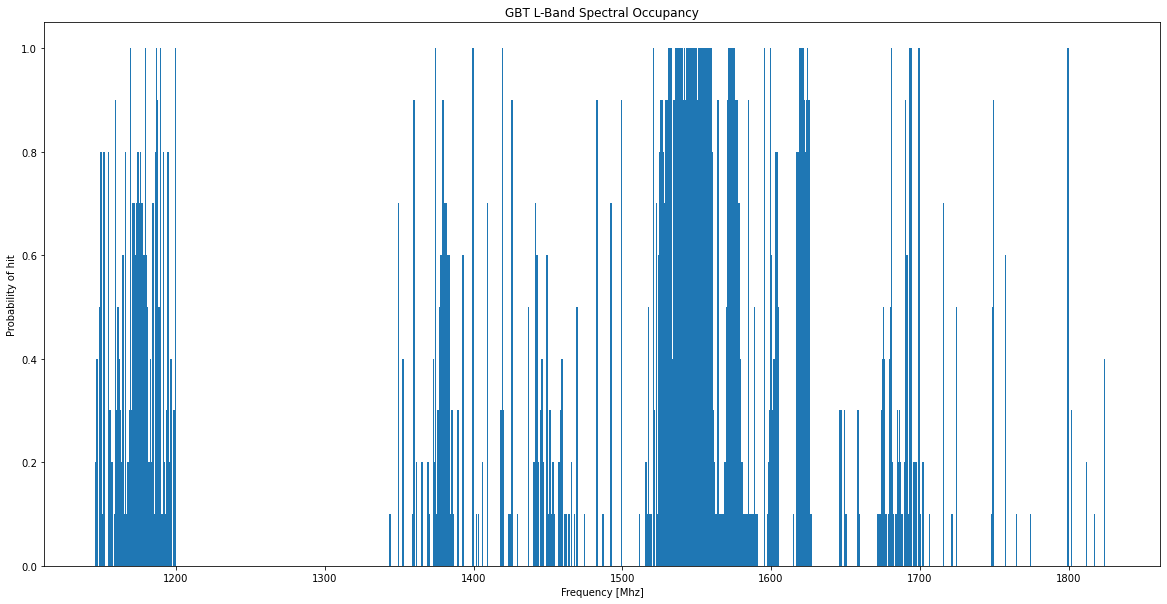

In [17]:
plt.figure(figsize=(20, 10))
plt.bar(bin_edges[:-1], prob_hist, width=.99)
plt.xlabel("Frequency [Mhz]")
plt.ylabel("Probability of hit")
plt.title("GBT L-Band Spectral Occupancy")
plt.savefig("Spectral_Occupancy_modified.png")
#plt.xlim(1710, 1750)
plt.show()

In [118]:
tbl = find.read_dat(dat_files[1])
float(tbl["DELTAF"][0])*1e-6
tbl["Freq"][0]

1926.0